In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
print("OpenCV version:", cv.__version__)

OpenCV version: 4.10.0


In [2]:
!wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/data/coins.png -O coins.png
import os

if not os.path.exists('coins.png'):
    print("coins.png download failed. Please upload an image named 'coins.png' or change path.")
else:
    print("coins.png is ready.")

coins.png is ready.


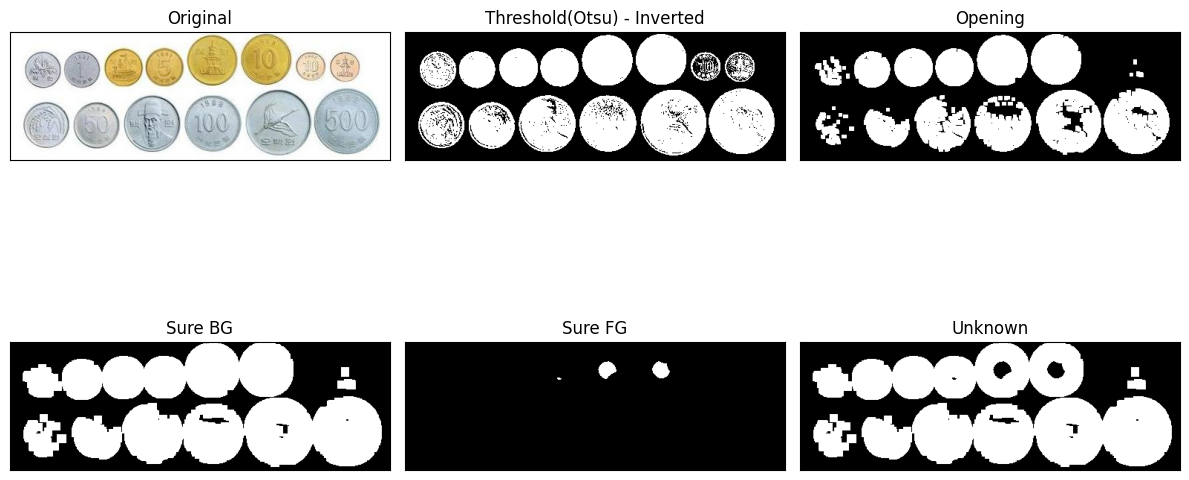

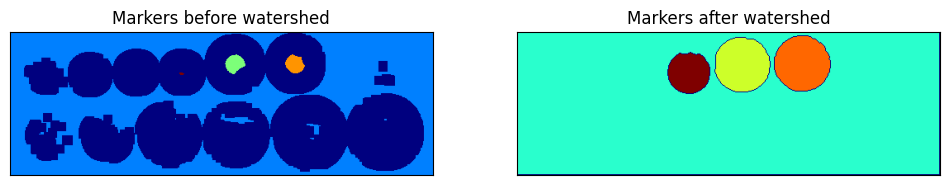

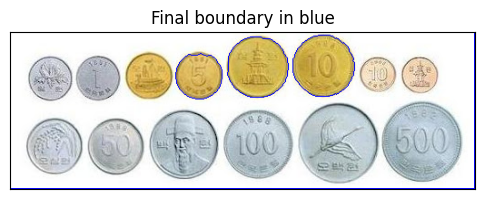

In [5]:
img = cv.imread('coins.jpg')
if img is None:
    raise FileNotFoundError("coins.png not found.")

# 1) 그레이 & 이진화(거꾸로) -> Otsu
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# 2) 노이즈 제거: Morphology opening
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

# 3) sure background: dilation
sure_bg = cv.dilate(opening, kernel, iterations=3)

# 4) sure foreground: distance transform + threshold
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
dist_max = dist_transform.max()
ret, sure_fg = cv.threshold(dist_transform, 0.7*dist_max, 255, 0)

# 5) unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

# 6) marker labeling
ret, markers = cv.connectedComponents(sure_fg)
# background label = 0, so we do +1 so background=1
markers = markers + 1
# unknown region = 0
markers[unknown==255] = 0

# 7) watershed
markers_ws = markers.copy()
cv.watershed(img, markers_ws)

# 결과 부분은 -1로 표시됨, 경계 픽셀을 (255, 0, 0)로 칠하기
img_ws = img.copy()
img_ws[markers_ws == -1] = [255, 0, 0]

# 시각화
plt.figure(figsize=(12,8))
plt.subplot(2,3,1), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,2), plt.imshow(thresh, cmap='gray')
plt.title('Threshold(Otsu) - Inverted'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,3), plt.imshow(opening, cmap='gray')
plt.title('Opening'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,4), plt.imshow(sure_bg, cmap='gray')
plt.title('Sure BG'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,5), plt.imshow(sure_fg, cmap='gray')
plt.title('Sure FG'), plt.xticks([]), plt.yticks([])

plt.subplot(2,3,6), plt.imshow(unknown, cmap='gray')
plt.title('Unknown'), plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1), plt.imshow(markers, cmap='jet')
plt.title('Markers before watershed'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(markers_ws, cmap='jet')
plt.title('Markers after watershed'), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(cv.cvtColor(img_ws, cv.COLOR_BGR2RGB))
plt.title('Final boundary in blue'), plt.xticks([]), plt.yticks([])
plt.show()